<a href="https://colab.research.google.com/github/CFVV/MSc-assignments/blob/main/2021-1_Deep_learning/T1_ConvolutionalNeuralNetworks(CNNs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# TAREA 1: REDES NEURONALES CONVOLUCIONALES (CCNs)
## IIC3697 - Aprendizaje Profundo

Departamento de Ciencia de la Computación

Pontificia Universidad Católica de Chile

Camila F. Vera Villa

# 0. SETUP INICIAL

Obtener memoria libre de la GPU

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0] # Only one GPU on Colab and isn’t guaranteed
def printm():
    process = psutil.Process(os.getpid())
    print('Gen RAM Free: ' + humanize.naturalsize(
        psutil.virtual_memory().available),'IProcsize:'+
        humanize.naturalsize(process.memory_info().rss))
    print('GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total{3:.0f}MB'.format(
        gpu.memoryFree,gpu.memoryUsed, gpu.memoryUtil*100,gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=cc1cd1c5e59e88133358609a53cdf112ec0e5da051b01b7df317f72b84e6778c
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB IProcsize:117.8 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total15109MB


Instalación de librerías

In [ ]:
!pip install torch-lucent
!pip install torch-summary
!pip install python-utils
!pip install opencv-transforms
!pip install transforms
!pip install pycocotools --quiet
!pip install pycocotools
!pip install albumentations==0.4.6
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0
!pip install Cython


     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 225kB 10.6MB/s 
ERROR: pytest-mock 3.6.1 has requirement pytest>=5.0, but you'll have pytest 3.6.4 which is incompatible.
  Created wheel for transforms: filename=transforms-0.1-cp37-none-any.whl size=39350 sha256=1ffffa0573e9b4000916187186f12ac876429b66f41c3564c5a70703a6204f3a
  Stored in directory: /root/.cache/pip/wheels/9a/37/f1/418005fb3d7a7587348cde9f4e44b7df3b3b9f4f37977cc5e8
Successfully built transforms
     |████████████████████████████████| 122kB 8.4MB/s 
     |████████████████████████████████| 952kB 26.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65163 sha256=82a59e19664748107665c9307affc0598b76ca69932ff4236c1ee6e6fd37c01c
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2

### Import de librerías necesarias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sn
import time
import os
import copy
import cv2
import warnings
warnings.filterwarnings('ignore')
##### Lucent
from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo.util import get_model_layers
##### Keras
import keras
import tensorflow as t
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input, Activation, merge
from keras.optimizers import RMSprop
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D,Conv2D
import keras.preprocessing.image as image
from keras.utils.data_utils import get_file
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
##### Pytorch
import random
import torch
import torchvision
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from tqdm import tqdm
from os import listdir
from os.path import join
from PIL import Image
from torchvision.transforms import Compose, ToTensor, Resize
from __future__ import print_function
from __future__ import division
import torch.nn as nn
from torchvision import datasets, models, transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#### otras
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
#!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./
!cp vision/references/detection/group_by_aspect_ratio.py ./
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
#from engine import train_one_epoch, evaluate
import xml.etree.ElementTree as et
import utils
import cython

seed = 254
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
torch.manual_seed(seed)
print(f"Seed: {seed}")


PyTorch Version:  1.8.1+cu101
Torchvision Version:  0.9.1+cu101
Seed: 254


Cuda

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# I. PARTE 1: ResNet-50 (20 %).
Para ilustrar la implementación de CNNs en Keras, estudiaremos en profundidad una de las estructuras más populares del 2015: Resnet-50


Para implementar esta red en Keras, comenzaremos creando las primeras capas del modelo:

In [ ]:
Inputs = Input(shape=(224,224,3))

x = ZeroPadding2D((1,1))(Inputs)
x = Conv2D(64, (7, 7), strides=(2, 2), name="conv1",padding='same', use_bias=False)(Inputs)
print(x.shape)
x = BatchNormalization(name="bn_conv1")(x)
x = Activation("relu")(Inputs)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

model_1 = Model(Inputs, x)
model_1.summary()

(None, 112, 112, 64)
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
activation_164 (Activation)  (None, 224, 224, 3)       0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 111, 111, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


Model

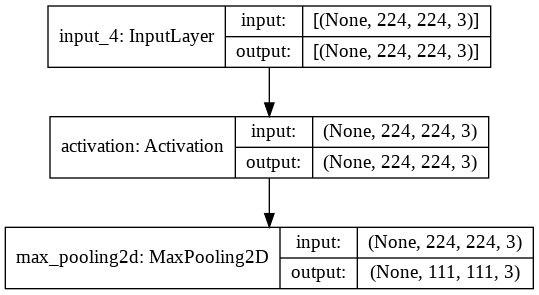

In [ ]:
keras.utils.plot_model(model, "conv1.png", show_shapes=True)


Una vez definidas las primeras capas, procedemos a agregar la primera etapa de bloques residuales:


**Identity block**

In [ ]:
def identity_block(input, filters, stage, block):

  name = f"block_{block}_stage_{stage}"

  f1, f2, f3 = filters

  #primera capa
  x = Conv2D(filters= f1, kernel_size= (1,1), strides= (1,1), padding= "valid", name= name)(input) # complete el codigo
  x = BatchNormalization(name = "bn1_" + name)(x)
  x = Activation("relu")(x)

  #segunda capa
  x = Conv2D(filters= f2, kernel_size= (3,3), strides= (1,1), padding= "same")(x) # complete el codigo
  x = BatchNormalization(name = "bn2_" + name)(x)
  x = Activation("relu")(x)

  #tercera capa
  x = Conv2D(filters= f3, kernel_size= (1,1), strides= (1,1), padding= "valid")(x) # complete el codigo
  x = BatchNormalization(name = "bn3_" + name)(x)

  x = layers.Add()([x, input])
  x = Activation("relu")(x)

  return x


**Convolutional Block**


In [ ]:
def convolutional_block(input, filters, stage, block):

  name = f"block_{block}_stage_{stage}"

  f1, f2, f3 = filters

  input_shortcut = input

  #primera capa
  x = Conv2D(filters= f1, kernel_size= (1,1), strides= (2,2), name= name)(input)
  x = BatchNormalization(name = "bn1_" + name)(x)
  x = Activation("relu")(x)

  #segunda capa
  x = Conv2D(filters= f2, kernel_size= (3,3), strides= (1,1), padding= "same")(x)
  x = BatchNormalization(name = "bn2_" + name)(x)
  x = Activation("relu")(x)

  #tercera capa
  x = Conv2D(filters= f3, kernel_size= (1,1), strides= (1,1), padding= "valid")(x)
  x = BatchNormalization(name = "bn3_" + name)(x)

  #shortcut
  x_shortcut = Conv2D(filters= f3, kernel_size= (1,1), strides= (2,2), padding= "valid")(input_shortcut)
  x_shortcut = BatchNormalization(name = "bn_shortcut_" + name)(x_shortcut)

  x = layers.Add()([x, x_shortcut])
  x = Activation("relu")(x)

  return x

## Actividad 1
Investigue y explique en no más de tres líneas la utilidad de una capa de convolución con kernel de 1x1.

### **Respuesta:**  
Una capa de convolución con kernel 1x1 ofrece una agrupación de canales llamado *feature map pooling* que se puede usar para *aumentar o disminuir la dimensionalidad del filtro  conservando sus características más destacadas*, esto para abordar el problema del aumento de parámetros de las Deep CNNs cuando aumenta la profundidad de la red y así disminuir el costo de cálculo computacional.

## Actividad 2
ResNet utiliza los denominados bloques residuales, según muestra la figura 2.

Investigue e indique en no más de 5 líneas la teoría, funcionamiento y utilidad de estos bloques.

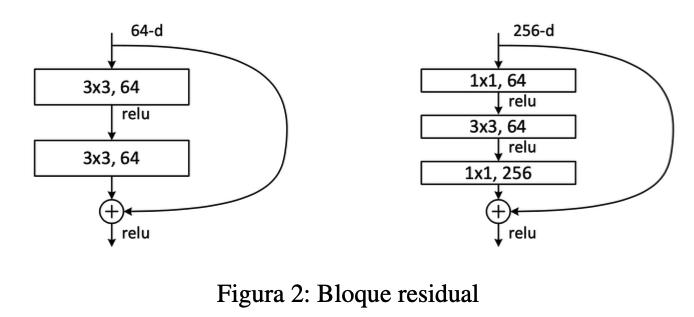

### **Respuesta:**
Los bloques residuales permiten a la red aprender la *función identidad* en sus distintas secciones.
Los bloques convolucionales que están dentro del bloque le permiten a la red aprender atributos, una funcion f(x) sobre una función de entrada. En caso de que no sea necesario aplicar una funcion dentro del bloque, el skip connection permite traspasar el tensor entrante directaente hacia el final del bloque, permitiendo que en el caso de que no sea necesario aplicar una transformación sobre el tensor de entrada, pueda aprender la función nula en f(x).



## Actividad 3
Complete el código presentado anteriormente e indique las dimensiones del tensor resultante a la salida de la primera etapa de bloques residuales.

### **Respuesta**:
El tensor resultante a la salida  de la primera etapa de bloques residuales tienen dimensión de 56x56x256

In [ ]:
Inputs = Input(shape=(224,224,3))

x= Conv2D(64, (7, 7), strides=(2, 2), name="conv1", padding = "same", use_bias=False)(Inputs)
#print(x.shape)
x = BatchNormalization(name="bn_conv1")(x)
x = Activation("relu")(Inputs)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

#segunda etapa (primera etapa residual)
x = convolutional_block(x, [64,64,256], stage = 2, block= "a")
x = identity_block(x, [64,64,256], stage = 2, block= "b")
x = identity_block(x, [64,64,256], stage = 2, block= "c")


model = Model(Inputs, x)
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
activation_165 (Activation)     (None, 224, 224, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 111, 111, 3)  0           activation_165[0][0]             
__________________________________________________________________________________________________
block_a_stage_2 (Conv2D)        (None, 56, 56, 64)   256         max_pooling2d_12[0][0]           
___________________________________________________________________________________________

## Actividad 4
Basándose en la arquitectura de la red, modele las etapas 2, 3 y 4, e indique las dimensiones del tensor resultante a la salida de cada bloque residual.

### **Respuesta**:
 Las dimensiones de los tensores resultantes son:
*   segunda etapa: 56x56x256
*   tercera etapa: 28x28x512
*   cuarta etapa: 14x14x1024
*   quinta etapa: 7x7x2048

El modelado se muestra en el código siguiente:


In [ ]:
Inputs = Input(shape=(224,224,3))

x= Conv2D(64, (7, 7), strides=(2, 2), name="conv1",padding='same', use_bias=False)(Inputs)
print(x.shape)
x = BatchNormalization(name="bn_conv1")(x)
x = Activation("relu")(Inputs)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

#segunda etapa
x = convolutional_block(x, [64,64,256], stage = 2, block= "a")
x = identity_block(x, [64,64,256], stage = 2, block= "b")
x = identity_block(x, [64,64,256], stage = 2, block= "c")

#tercera etapa
x = convolutional_block(x, [128,128,512], stage = 3, block= "a")
x = identity_block(x, [128,128,512], stage = 3, block= "b")
x = identity_block(x, [128,128,512], stage = 3, block= "c")
x = identity_block(x, [128,128,512], stage = 3, block= "d")

#cuarta etapa
x = convolutional_block(x, [256,256,1024], stage = 4, block= "a")
x = identity_block(x, [256,256,1024], stage = 4, block= "b")
x = identity_block(x, [256,256,1024], stage = 4, block= "c")
x = identity_block(x, [256,256,1024], stage = 4, block= "d")
x = identity_block(x, [256,256,1024], stage = 4, block= "e")
x = identity_block(x, [256,256,1024], stage = 4, block= "f")

#quinta etapa
x = convolutional_block(x, [512,512,2048], stage = 5, block= "a")
x = identity_block(x, [512,512,2048], stage = 5, block= "b")
x = identity_block(x, [512,512,2048], stage = 5, block= "c")


model = Model(Inputs, x)
model.summary()

(None, 112, 112, 64)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
activation_111 (Activation)     (None, 224, 224, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 111, 111, 3)  0           activation_111[0][0]             
__________________________________________________________________________________________________
block_a_stage_2 (Conv2D)        (None, 56, 56, 64)   256         max_pooling2d_6[0][0]            
_______________________________________________________________________

## Actividad 5
Implemente la etapa final de clasificación utilizando en la capa final una función de activación del tipo Softmax.

### **Respuesta**:
La implementación se muestra en el código siguiente:

In [ ]:
def ResNet50(input_shape=(224,224,3), classes = 1000):

  # define el input
  x_input = Input(input_shape)

  # zero-padding
  x = ZeroPadding2D((3,3))(x_input) # 3,3 padding

  # primera etapa
  x = Conv2D(64, (7, 7), strides=(2, 2))(x_input)
  x = BatchNormalization(axis= 3)(x)
  x = Activation("relu")(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #segunda etapa
  x = convolutional_block(x, [64,64,256], stage = 2, block= "a")
  x = identity_block(x, [64,64,256], stage = 2, block= "b")
  x = identity_block(x, [64,64,256], stage = 2, block= "c")

  #tercera etapa
  x = convolutional_block(x, [128,128,512], stage = 3, block= "a")
  x = identity_block(x, [128,128,512], stage = 3, block= "b")
  x = identity_block(x, [128,128,512], stage = 3, block= "c")
  x = identity_block(x, [128,128,512], stage = 3, block= "d")

  #cuarta etapa
  x = convolutional_block(x, [256,256,1024], stage = 4, block= "a")
  x = identity_block(x, [256,256,1024], stage = 4, block= "b")
  x = identity_block(x, [256,256,1024], stage = 4, block= "c")
  x = identity_block(x, [256,256,1024], stage = 4, block= "d")
  x = identity_block(x, [256,256,1024], stage = 4, block= "e")
  x = identity_block(x, [256,256,1024], stage = 4, block= "f")

  #quinta etapa
  x = convolutional_block(x, [512,512,2048], stage = 5, block= "a")
  x = identity_block(x, [512,512,2048], stage = 5, block= "b")
  x = identity_block(x, [512,512,2048], stage = 5, block= "c")

  #AvgPool
  x = AveragePooling2D((2,2), name= "avg_pool")(x)

  # output layer
  x = Flatten()(x)
  x = Dense(classes, activation= "softmax", name= "fc" + str(classes), kernel_initializer= glorot_uniform(seed= 0))(x)

  # creación del odelo
  model = Model(inputs = x_input, outputs = x, name = "ResNet50")

  return model

## Actividad 6
Implemente una función para generar bloques residuales. Utilizando esta función instancie el modelo de la red. Luego, verifique la dimensionalidad de las capas. Reporte su función  para instanciar la red. Tipo: model = mi_resnet()

### **Respuesta**:
La función se desarrolló en la Actividad 5:

```
def ResNet50(input_shape=(224,224,3), classes = 1000):
```

La instancia del modelo de la red está en el siguiente código :

In [ ]:
model =ResNet50(input_shape= (224,224,3), classes= 1000)

In [ ]:
model.compile(optimizer= "adam", loss= "categorical_crossentropy", metrics= ["accuracy"])

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_147 (Conv2D)             (None, 109, 109, 64) 9472        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 109, 109, 64) 256         conv2d_147[0][0]                 
__________________________________________________________________________________________________
activation_199 (Activation)     (None, 109, 109, 64) 0           batch_normalization_3[0][0]      
___________________________________________________________________________________________

Modelo


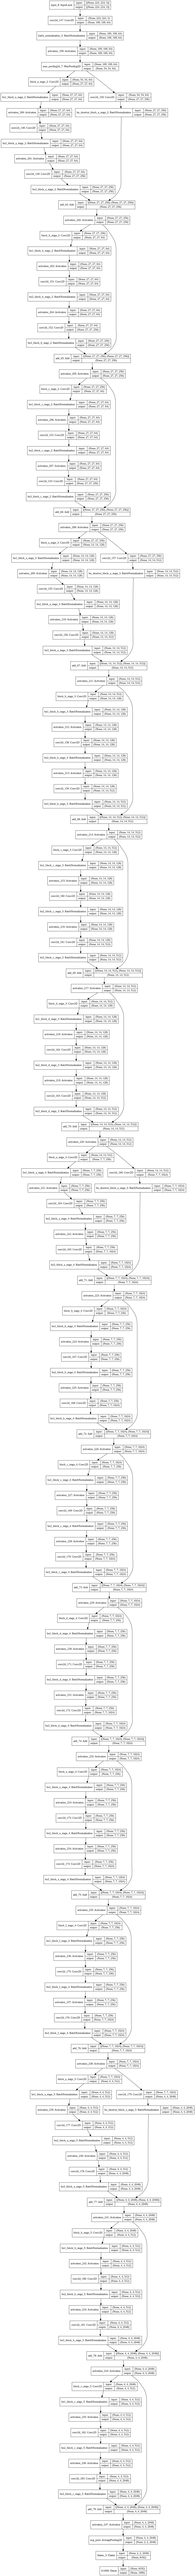

In [ ]:
print("Modelo")
keras.utils.plot_model(model, "resnet50.png", show_shapes=True)

# II. Parte 2: Análisis de redes (40%)
En esta sección exploraremos técnicas de visualización en redes neuronales, tanto de sus representaciones internas (feature visualization), como de las partes del input que son responsables del output (attribution). Para este propósito utilizaremos las librerías  Lucent y PyTorch.

Pytorch nos permite instanciar modelos como Alexnet, VGG, ResNet o Inception, junto con la posibilidad de descargar pesos pre-entrenados utilizando el dataset ImageNet. Para ello debemos utilizar torchvision, una librería de pytorch enfocada en el trabajo con imágenes.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alexnet = models.alexnet(pretrained=True).to(device).eval()
googlenet = models.googlenet(pretrained=True).to(device).eval()
vgg19 = models.vgg19(pretrained=True).to(device).eval()
resnet50 = models.resnet50(pretrained=True).to(device).eval()

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Ahora que tenemos los modelos en Pytorch, visualizaremos sus representaciones internas en distintas capas. Para ellos utilizaremos la librería torch-lucent y matplotlib.


A modo de ejemplo utilizaremos AlexNet, cuya arquitectura se presenta en la figura 3.
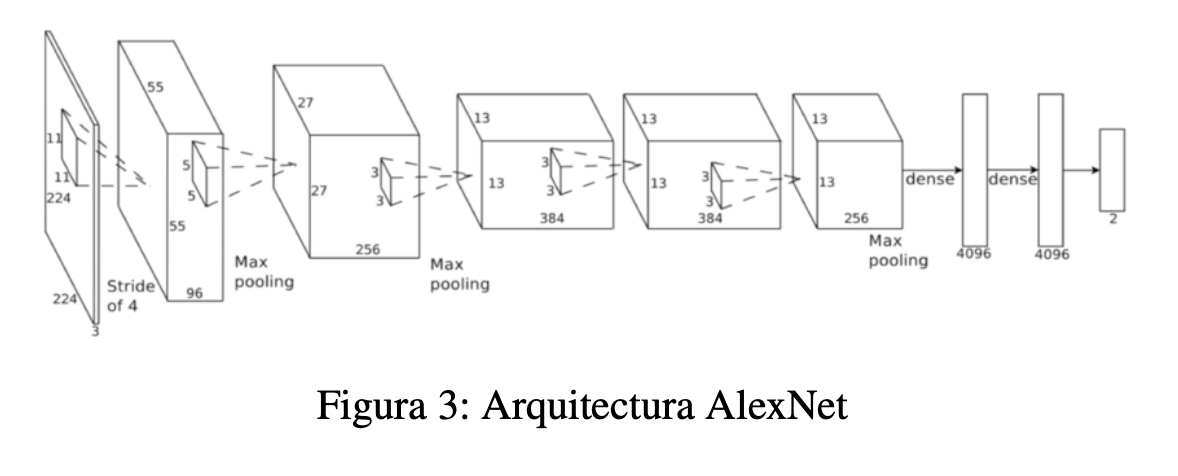

Primero debemos ver los elementos que conforman la red importada desde PyTorch.

El output nos indica que el modelo posee 12 capas de features, sin embargo, AlexNet posee 5 capas convolucionales.

Para referirnos a cada una de las 5 capas convolucionales, debemos considerar features 1, features 4, features 7, features 9 y features 11, ya que corresponden a la salida de la respectiva convolucio ́n despue ́s de la aplicacio ́n de la funcio ́n de activacio ́n.


In [ ]:
get_model_layers(alexnet)

['features',
 'features_0',
 'features_1',
 'features_2',
 'features_3',
 'features_4',
 'features_5',
 'features_6',
 'features_7',
 'features_8',
 'features_9',
 'features_10',
 'features_11',
 'features_12',
 'avgpool',
 'classifier',
 'classifier_0',
 'classifier_1',
 'classifier_2',
 'classifier_3',
 'classifier_4',
 'classifier_5',
 'classifier_6']

Respresentación de features.

Visualización del canal 68 de la capa 5 de AlexNet:

100%|██████████| 512/512 [00:03<00:00, 133.42it/s]



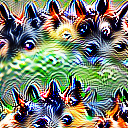

In [ ]:
 _ = render.render_vis(alexnet, "features_11:68", show_inline=True) # show_inline =True despliega la imagen encontrada

 Representación de Labels

Visualización de una imagen correspondiente a alguna de las clases del set de datos. Para ello usamos el formato labels:  índice de la clase.

100%|██████████| 512/512 [02:01<00:00,  4.23it/s]



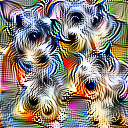

In [ ]:

_ = render.render_vis(alexnet, "labels:196", show_inline=True)

## Actividad 7
Seleccione una red entre VGG, Resnet e Inception y reporte la visualización  de 3 canales (filtros) para mapas de activación correspondientes a capas iniciales, intermedias y finales de la red seleccionada. Puede ver las implementaciones de las redes en https://github.com/pytorch/vision/tree/master/torchvision/models.

Comente brevemente sus impresiones sobre las visualizaciones obtenidas


### **Respuesta**:
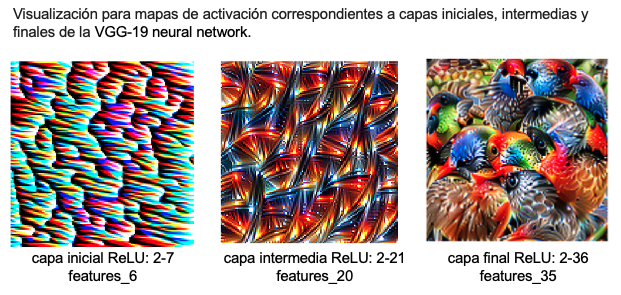

Las visualizaciones muestran que en las capas iniciales la imagen es difusa en forma y color; en capas intermedias ya los contornos y colores están más definidos logrando generar un patrón más nítido, sin embargo, aún no se aprecian formas claras, ya en la capa final se pueden ver formas más definidas y colores más nítidos, la imagen se puede asociar con aves.

VGG-19 neural network

In [ ]:
get_model_layers(vgg19)

['features',
 'features_0',
 'features_1',
 'features_2',
 'features_3',
 'features_4',
 'features_5',
 'features_6',
 'features_7',
 'features_8',
 'features_9',
 'features_10',
 'features_11',
 'features_12',
 'features_13',
 'features_14',
 'features_15',
 'features_16',
 'features_17',
 'features_18',
 'features_19',
 'features_20',
 'features_21',
 'features_22',
 'features_23',
 'features_24',
 'features_25',
 'features_26',
 'features_27',
 'features_28',
 'features_29',
 'features_30',
 'features_31',
 'features_32',
 'features_33',
 'features_34',
 'features_35',
 'features_36',
 'avgpool',
 'classifier',
 'classifier_0',
 'classifier_1',
 'classifier_2',
 'classifier_3',
 'classifier_4',
 'classifier_5',
 'classifier_6']

Summary del modelo


In [ ]:
torchsummary.summary(vgg19, (3, 64, 64));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 2, 2]           --
|    └─Conv2d: 2-1                       [-1, 64, 64, 64]          1,792
|    └─ReLU: 2-2                         [-1, 64, 64, 64]          --
|    └─Conv2d: 2-3                       [-1, 64, 64, 64]          36,928
|    └─ReLU: 2-4                         [-1, 64, 64, 64]          --
|    └─MaxPool2d: 2-5                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-6                       [-1, 128, 32, 32]         73,856
|    └─ReLU: 2-7                         [-1, 128, 32, 32]         --
|    └─Conv2d: 2-8                       [-1, 128, 32, 32]         147,584
|    └─ReLU: 2-9                         [-1, 128, 32, 32]         --
|    └─MaxPool2d: 2-10                   [-1, 128, 16, 16]         --
|    └─Conv2d: 2-11                      [-1, 256, 16, 16]         295,168
|    └─ReLU: 2-12                        [-1, 256, 16, 16]      

1. Visualización capa inicial




  0%|          | 0/512 [00:00<?, ?it/s]


  0%|          | 1/512 [00:00<06:17,  1.35it/s]


  0%|          | 2/512 [00:01<06:17,  1.35it/s]


  1%|          | 3/512 [00:02<06:20,  1.34it/s]


  1%|          | 4/512 [00:03<06:20,  1.34it/s]


  1%|          | 5/512 [00:03<06:19,  1.34it/s]


  1%|          | 6/512 [00:04<06:17,  1.34it/s]


  1%|▏         | 7/512 [00:05<06:18,  1.34it/s]


  2%|▏         | 8/512 [00:05<06:15,  1.34it/s]


  2%|▏         | 9/512 [00:06<06:15,  1.34it/s]


  2%|▏         | 10/512 [00:07<06:15,  1.34it/s]


  2%|▏         | 11/512 [00:08<06:13,  1.34it/s]


  2%|▏         | 12/512 [00:08<06:14,  1.33it/s]


  3%|▎         | 13/512 [00:09<06:12,  1.34it/s]


  3%|▎         | 14/512 [00:10<06:11,  1.34it/s]


  3%|▎         | 15/512 [00:11<06:10,  1.34it/s]


  3%|▎         | 16/512 [00:11<06:08,  1.34it/s]


  3%|▎         | 17/512 [00:12<06:09,  1.34it/s]


  4%|▎         | 18/512 [00:13<06:09,  1.34it/s]


  4%|▎         | 19/512 [00:14<06:06,  1.35it/


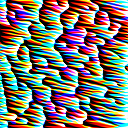

In [ ]:
 _ = render.render_vis(vgg19, "features_6:20", show_inline=True)

2. Visualización capa intermedia




  0%|          | 0/512 [00:00<?, ?it/s]


  0%|          | 1/512 [00:01<10:01,  1.18s/it]


  0%|          | 2/512 [00:02<10:03,  1.18s/it]


  1%|          | 3/512 [00:03<10:01,  1.18s/it]


  1%|          | 4/512 [00:04<10:03,  1.19s/it]


  1%|          | 5/512 [00:05<09:59,  1.18s/it]


  1%|          | 6/512 [00:07<09:56,  1.18s/it]


  1%|▏         | 7/512 [00:08<09:58,  1.19s/it]


  2%|▏         | 8/512 [00:09<09:54,  1.18s/it]


  2%|▏         | 9/512 [00:10<09:54,  1.18s/it]


  2%|▏         | 10/512 [00:11<09:51,  1.18s/it]


  2%|▏         | 11/512 [00:12<09:49,  1.18s/it]


  2%|▏         | 12/512 [00:14<09:48,  1.18s/it]


  3%|▎         | 13/512 [00:15<09:47,  1.18s/it]


  3%|▎         | 14/512 [00:16<09:43,  1.17s/it]


  3%|▎         | 15/512 [00:17<09:43,  1.17s/it]


  3%|▎         | 16/512 [00:18<09:45,  1.18s/it]


  3%|▎         | 17/512 [00:20<09:44,  1.18s/it]


  4%|▎         | 18/512 [00:21<09:41,  1.18s/it]


  4%|▎         | 19/512 [00:22<09:38,  1.17s/i


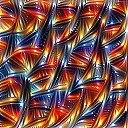

In [ ]:
_ = render.render_vis(vgg19, "features_20:40", show_inline=True)

3. Visualización capa final




  0%|          | 0/512 [00:00<?, ?it/s]


  0%|          | 1/512 [00:01<13:34,  1.59s/it]


  0%|          | 2/512 [00:03<13:22,  1.57s/it]


  1%|          | 3/512 [00:04<13:17,  1.57s/it]


  1%|          | 4/512 [00:06<13:07,  1.55s/it]


  1%|          | 5/512 [00:07<13:07,  1.55s/it]


  1%|          | 6/512 [00:09<13:00,  1.54s/it]


  1%|▏         | 7/512 [00:10<12:58,  1.54s/it]


  2%|▏         | 8/512 [00:12<12:54,  1.54s/it]


  2%|▏         | 9/512 [00:13<12:51,  1.53s/it]


  2%|▏         | 10/512 [00:15<12:47,  1.53s/it]


  2%|▏         | 11/512 [00:16<12:49,  1.53s/it]


  2%|▏         | 12/512 [00:18<12:50,  1.54s/it]


  3%|▎         | 13/512 [00:20<12:48,  1.54s/it]


  3%|▎         | 14/512 [00:21<12:45,  1.54s/it]


  3%|▎         | 15/512 [00:23<12:42,  1.53s/it]


  3%|▎         | 16/512 [00:24<12:39,  1.53s/it]


  3%|▎         | 17/512 [00:26<12:38,  1.53s/it]


  4%|▎         | 18/512 [00:27<12:38,  1.54s/it]


  4%|▎         | 19/512 [00:29<12:38,  1.54s/i


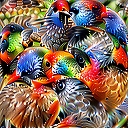

In [ ]:
_ = render.render_vis(vgg19, "features_35:20", show_inline=True)

## Actividad 8
Seleccione cualquiera de las redes preentrenadas disponibles en torchvision y modifique el head de clasificación  para se que sea compatible con el dataset de flores disponible en https://drive.google.com/drive/folders/1jliZUDwJ4t0RpNB7SEexz6yuieAfBV80.

Utilizando los pesos pre- entrenados como punto de partida, re-entrene la red (fine-tuning) para clasificar los datos del set de flores. Reporte sus resultados a través de los siguientes graficos:

*   Evolución de perdida respecto de las épocas de entrenamiento.
*   Evolución de la exactitud de clasificación sobre el set de entrenamiento y validación.
*    Analice y comente brevemente los gráficos anteriores.


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_fijo = '/content/drive/MyDrive/Magíster en Ciencias de la Ingeniería UC/2021-1_Deep_learning'

### **Respuesta:**

In [ ]:
import torchvision.models as models

In [ ]:
import torch.nn as nn

Modelo Resnet50

In [ ]:
from collections import OrderedDict

resnet50_finetune = models.resnet50(pretrained = True)
num_ftrs = resnet50_finetune.fc.in_features
resnet50_finetune.fc = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(num_ftrs, num_ftrs)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(num_ftrs, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

print(repr(resnet50_finetune))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

Las componentes de la red funcionan como atributos del objeto por lo que pueden ser recuperados como tal:

In [ ]:
resnet50_finetune.fc

Sequential(
  (fc1): Linear(in_features=2048, out_features=2048, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=2048, out_features=102, bias=True)
  (output): LogSoftmax(dim=1)
)

Como lo que se quiere es hacer finetuning, hay que re-entrenar todos los pesos, por lo que hay que activar `requires_grad` en todas las capas, sin embargo, por defecto cuando se carga un modelo este viene con sus capas activadas para entrenamiento, lo mismo cuandos creamos la capa anterior.

In [ ]:
summary(resnet50_finetune.to('cpu'), (3, 523, 500), device = 'cpu');

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 262, 250]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 262, 250]        128
├─ReLU: 1-3                              [-1, 64, 262, 250]        --
├─MaxPool2d: 1-4                         [-1, 64, 131, 125]        --
├─Sequential: 1-5                        [-1, 256, 131, 125]       --
|    └─Bottleneck: 2-1                   [-1, 256, 131, 125]       --
|    |    └─Conv2d: 3-1                  [-1, 64, 131, 125]        4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 131, 125]        128
|    |    └─ReLU: 3-3                    [-1, 64, 131, 125]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 131, 125]        36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 131, 125]        128
|    |    └─ReLU: 3-6                    [-1, 64, 131, 125]        --
|    |    └─Conv2d: 3-7                  [-1, 256, 131, 125]       16,38

Creación de los Datasets

In [ ]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Resize((224, 224)),
                                             torchvision.transforms.Normalize(
                                                 mean=[0.485, 0.456, 0.406],
                                                 std=[0.229, 0.224, 0.225])])

In [ ]:
#train
image_dataset_train = datasets.ImageFolder(path_fijo + '/flowers_dataset/train/', transform = transforms)
train_loader = DataLoader(dataset = image_dataset_train, batch_size = 64, shuffle = True)
#validation
image_dataset_validation = datasets.ImageFolder(path_fijo + '/flowers_dataset/val/', transform = transforms)
val_loader = DataLoader(dataset = image_dataset_validation, batch_size = 64, shuffle = True)
#test
image_dataset_test = datasets.ImageFolder(path_fijo + '/flowers_dataset/test/', transform = transforms)
test_loader = DataLoader(dataset = image_dataset_test, batch_size = 1, shuffle = True)

In [ ]:
def get_accuracy(yhat, y):
    batch_size = y.shape[0]
    yhat_reduced = torch.argmax(torch.softmax(torch.sigmoid(yhat), dim = 1), axis = 1)
    return torch.sum(yhat_reduced == y).cpu().numpy()/batch_size


def make_train_step(model, loss_fn, optimizer):
    """ Builds a function to perform a single step in the training loop"""

    def train_step(x,y):
        model.train() # Set model to train mode

        yhat = model(x) # Make prediction
        model_accuracy = multi_acc(yhat, y)

        loss = loss_fn(yhat, y) # Computes loss

        loss.backward() # Computes gradients

        optimizer.step() # Update parameters
        optimizer.zero_grad() # Zeroes the gradients

        return loss.item(), model_accuracy

    return train_step

def train_model(model, n_epochs, loss_fn, optimizer, train_loader, val_loader, device = 'cpu', shape = (3,224, 224)):
    losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    train_step = make_train_step(model, loss_fn, optimizer)

    for epoch in range(n_epochs):
        print(f'Epoch N°: {epoch+1}')
        for batch_n, (x_batch, y_batch) in enumerate(train_loader):
            print(f'\tBatch N°: {batch_n}')
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            loss, train_accuracy_batch = train_step(x_batch, y_batch)
            losses.append(loss)

            train_acc.append(train_accuracy_batch)
            print(f'\t  * Train loss: {losses[-1]}')
            print(f'\t  * Train Accuracy: {train_acc[-1]}')

            with torch.no_grad():
                val_losses_batch = []
                val_accuracy_batch = []
                for x_val, y_val in val_loader:
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)

                    model.eval()

                    yhat = model(x_val)
                    val_loss = loss_fn(yhat, y_val)

                    val_accuracy_batch.append(multi_acc(yhat, y_val))
                    val_losses_batch.append(val_loss.item())
                val_losses.append(np.mean(val_losses_batch))
                val_acc.append(np.mean(val_accuracy_batch))
                print(f'\t  * Val loss: {val_losses[-1]}')
                print(f'\t  * Val Accuracy: {val_acc[-1]}')

    return {'train_losses': losses, 'val_losses': val_losses, 'train_accuracy': train_acc, 'val_accuracy': val_acc}

def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)

    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)

    acc = acc * 100

    return acc.cpu().numpy()

Entrenamiento de la red:

In [ ]:
n_epochs = 3 # con 20 hay overfitting y el modelo ya converge a la época 3
loss_fn = nn.NLLLoss()
c

In [ ]:
resnet50_finetune.to(device);

In [ ]:
resnet50_finetune_dict = train_model(resnet50_finetune, n_epochs, loss_fn, optimizer, train_loader, val_loader, device = device)

NameError: ignored

In [ ]:
#torch.save(resnet50_finetune, 'resnet50_finetune_3Epoch.pt')

In [ ]:
resnet50_3epochs_flowers_finetuning = torch.load('/content/drive/MyDrive/Magíster en Ciencias de la Ingeniería UC/2021-1_Deep_learning/tarea1/resnet50_finetune_3Epoch.pt')

FileNotFoundError: ignored

Importación de modelo serializado con Pickle

In [ ]:
import pickle
#a_file = open("resnet50_finetune_3Epoch.pkl", "wb"
#pickle.dump(resnet50_finetune_dict, a_file)
#a_file.close()

a_file = open("/content/drive/MyDrive/Magíster en Ciencias de la Ingeniería UC/2021-1_Deep_learning/tarea1/resnet50_finetune_3Epoch.pkl", "rb")

resnet50_finetune_dict = pickle.load(a_file)


In [ ]:
# Llaves del diccionario
resnet50_finetune_dict.keys()

dict_keys(['train_losses', 'val_losses', 'train_accuracy', 'val_accuracy'])

**Gráfico 1:**
Evolución de perdida respecto de las 3 épocas de entrenamiento en que el modelo logró converger.


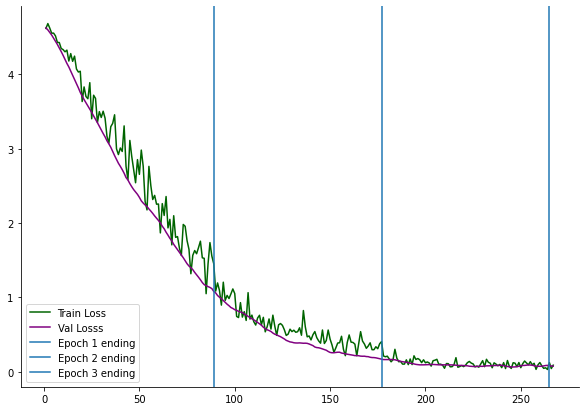

In [ ]:
fig, ax = plt.subplots(figsize = (10,7))

sn.lineplot(x = range(1, len(resnet50_finetune_dict['train_losses'])+1),
            y = resnet50_finetune_dict['train_losses'], ax = ax, label = 'Train Loss',color = 'darkgreen')
sn.lineplot(x = range(1, len(resnet50_finetune_dict['val_losses'])+1),
            y = resnet50_finetune_dict['val_losses'], ax = ax, label = 'Val Losss',color = 'purple')

for i, batch_n in enumerate(list(range(0,88*3+1, 88)[1:])):
  ax.axvline(batch_n+1, label = f'Epoch {i+1} ending')

sn.despine()
plt.legend();

**Gráfico 2:**
Evolución de la exactitud de clasificación sobre el set de entrenamiento y validación respecto de las 3 épocas de entrenamiento en que el modelo logró converger.

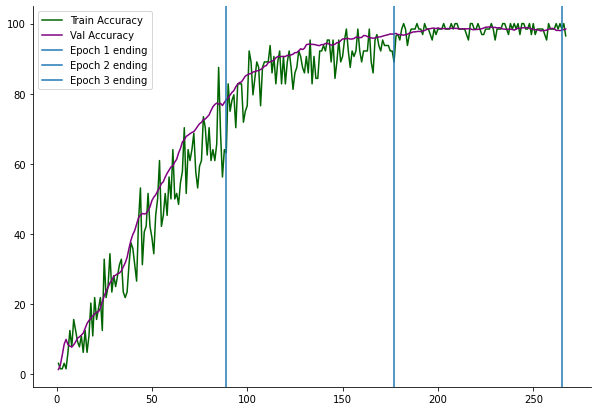

In [ ]:
fig, ax = plt.subplots(figsize = (10,7))

sn.lineplot(x = range(1, len(resnet50_finetune_dict['train_accuracy'])+1),
            y = [x.item() for x in resnet50_finetune_dict['train_accuracy']], ax = ax, label = 'Train Accuracy', color = 'darkgreen' )
sn.lineplot(x = range(1, len(resnet50_finetune_dict['val_accuracy'])+1),
            y = [x.item() for x in resnet50_finetune_dict['val_accuracy']], ax = ax, label = 'Val Accuracy', color = 'purple')

for i, batch_n in enumerate(list(range(0,88*3+1, 88)[1:])):
  ax.axvline(batch_n+1, label = f'Epoch {i+1} ending')

sn.despine()
plt.legend();

## Actividad 9
Para su modelo de clasificació de flores, utilizando Lucent, compare las features de una capa inicial, una capa intermedia y una capa final. También analice tres labels y compárelos con las imágenes de la clase correspondiente. Comente brevemente.

In [ ]:
import torch.nn as nn

In [ ]:
from torchsummary import summary

In [ ]:
get_model_layers(resnet50_3epochs_flowers_finetuning)

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer1_0',
 'layer1_0_conv1',
 'layer1_0_bn1',
 'layer1_0_conv2',
 'layer1_0_bn2',
 'layer1_0_conv3',
 'layer1_0_bn3',
 'layer1_0_relu',
 'layer1_0_downsample',
 'layer1_0_downsample_0',
 'layer1_0_downsample_1',
 'layer1_1',
 'layer1_1_conv1',
 'layer1_1_bn1',
 'layer1_1_conv2',
 'layer1_1_bn2',
 'layer1_1_conv3',
 'layer1_1_bn3',
 'layer1_1_relu',
 'layer1_2',
 'layer1_2_conv1',
 'layer1_2_bn1',
 'layer1_2_conv2',
 'layer1_2_bn2',
 'layer1_2_conv3',
 'layer1_2_bn3',
 'layer1_2_relu',
 'layer2',
 'layer2_0',
 'layer2_0_conv1',
 'layer2_0_bn1',
 'layer2_0_conv2',
 'layer2_0_bn2',
 'layer2_0_conv3',
 'layer2_0_bn3',
 'layer2_0_relu',
 'layer2_0_downsample',
 'layer2_0_downsample_0',
 'layer2_0_downsample_1',
 'layer2_1',
 'layer2_1_conv1',
 'layer2_1_bn1',
 'layer2_1_conv2',
 'layer2_1_bn2',
 'layer2_1_conv3',
 'layer2_1_bn3',
 'layer2_1_relu',
 'layer2_2',
 'layer2_2_conv1',
 'layer2_2_bn1',
 'layer2_2_conv2',
 'layer2_2_bn2',
 'layer

In [ ]:
summary(resnet50_3epochs_flowers_finetuning,(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

### **Respuesta:**
Para las capas, las visualizaciones muestran que en las capas iniciales la imagen es difusa en forma y color; en capas intermedias ya los contornos y colores están más definidos logrando generar un patrón más nítido, sin embargo, aún no se aprecian formas claras, ya en la capa final se pueden ver formas más definidas y colores más nítidos, sin embargo, aun no logro distinguir claramente formas de flores.

Para el caso de los labels no logro apreciar flores claramente,en este caso se renderizaron las clases 20,50 y 101.


CAPAS

1. Visualización capa inicial

100%|██████████| 512/512 [00:06<00:00, 83.18it/s]



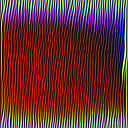

In [ ]:
 _ = render.render_vis(resnet50_3epochs_flowers_finetuning, "layer1_0_conv2:20", show_inline=True)

2. Visualización capa intermedia

100%|██████████| 512/512 [00:08<00:00, 61.07it/s]



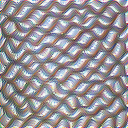

In [ ]:
 _ = render.render_vis(resnet50_3epochs_flowers_finetuning, "layer3_0_conv1:20", show_inline=True)

3. Visualización capa final

100%|██████████| 512/512 [00:11<00:00, 42.72it/s]



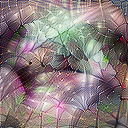

In [ ]:
 _ = render.render_vis(resnet50_3epochs_flowers_finetuning, "layer4_2_conv3:20", show_inline=True)

LABELS


100%|██████████| 512/512 [00:12<00:00, 41.15it/s]



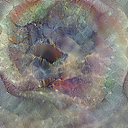

In [ ]:
_ = render.render_vis(resnet50_3epochs_flowers_finetuning, "labels:20", show_inline=True)

In [ ]:
_ = render.render_vis(resnet50_3epochs_flowers_finetuning, "labels:50", show_inline=True)

NameError: ignored

100%|██████████| 512/512 [00:12<00:00, 40.77it/s]



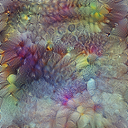

In [ ]:
_ = render.render_vis(resnet50_3epochs_flowers_finetuning, "labels:101", show_inline=True)

In [ ]:
import json
with open('/content/drive/MyDrive/Magíster en Ciencias de la Ingeniería UC/2021-1_Deep_learning/flowers_dataset/cat_to_name 2.json', 'r') as f:
    flower_to_name = json.load(f)

print(len(flower_to_name))
print(flower_to_name)

102
{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54'

# III. Parte 3: Detección de objetos(40%)
A lo largo de esta tarea han experimentado con modelos de clasificación de imágenes, analizado su aprendizaje y experimentado con entrenamiento y fine-tuning. En esta sección  pondrán  en práctica Lo que vimos en clases sobre técnicas de reconocimiento de objetos.

Para este propósito utilizaremos la red Faster R-CNN disponible en torchvision.

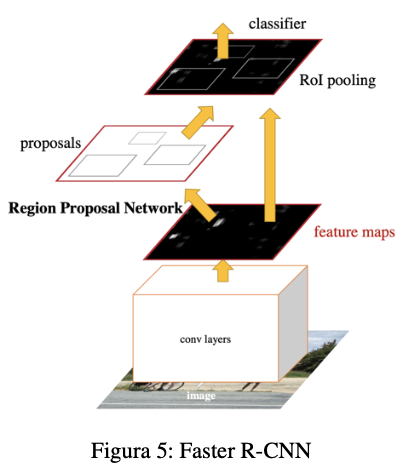

La librería considera el uso de varios modelos base (backbones), en esta actividad ocuparemos ResNet-50 Faster R-CNN. Para instanciar este modelo preentrenado se debe ejecutar un código similar al siguiente.

```
from torchvision.models.detection import fasterrcnn_resnet50_fpn

frcnn_model = fasterrcnn_resnet50_fpn(pretrained=True, progress=True,num_classes=91, pretrained_backbone=True, trainable_backbone_layers=3)
```



## Actividad 10
Investigue y explique, en no más de 10 líneas, el concepto de non-maximum suppresion en el contexto de reconocimiento de objetos. Adicionalmente, instancie e imprima el modelo para visualizar sus componentes. Explique en qué consisten los siguientes componentes (no más  de 5 líneas c/u): Backbone, Feature Pyramid Network (FPN) y RPN.

### **Respuesta:**
**Non-maximum suppresion.**

 Este método de post-procesamiento es un paso clave en varias aplicaciones de computer visión. Su necesidad surge de la imperfecta capacidad de los algoritmos de detección para localizar el concepto de interés, lo que da como resultado grupos de varias detecciones (bounding boxes) cerca de la ubicación real. En el contexto de la detección de objetos, se utiliza para ignorar los bounding boxes que tienen un traslape significativo con otros. Transforma muchas hipótesis de ventana en  -idealmente- un solo box delimitador para cada objeto detectado, correspondiente al máximo local preciso de la función de respuesta. Incluso para imágenes que contienen varios objetos, este método puede ignorar los cuadros delimitadores superpuestos más pequeños y devolver solo los más grandes. NMS también tiene un gran impacto positivo sobre las métricas de performance que penalizan las detecciones doble.

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
frcnn_model = fasterrcnn_resnet50_fpn(pretrained=True, progress=True,
num_classes=91, pretrained_backbone=True, trainable_backbone_layers=3)

In [ ]:
print(repr(frcnn_model))

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### **Respuesta:**
Explique en qué consisten los siguientes componentes:
1. Backbone
2. Feature Pyramid Network (FPN)
3. RPN


1. **Backbone**

Se refiere a la parte de la arquitectura de la red neuronal en donde se realiza la extracción de características. Este feature extractor se utiliza para codificar el input de la red en una determinada representación de características y permite elegir un modelo que se adapte a la tarea en términos de eficiencia (el rendimiento de los detectores de objetos se basa en gran medida en características extraídas por backbones).  Muchos detectores de objetos utilizan directamente redes diseñadas para la clasificación de imágenes como backbones, esto permite hacer finetuning (una forma de hacer transfer Learning)

2. **Feature Pyramid Network (FPN)**

FPN es una solución práctica y precisa para la detección de objetos de múltiples escalas y se construye rápidamente a partir de una escala de imagen de entrada única, sin sacrificar el poder de representación, la velocidad o la memoria y genera mapas de características de tamaño proporcional en múltiples niveles convolucionalmente; este proceso es independiente de las arquitecturas convolucionales backbones.

3. **Region Proposal Network (RPN)**
RPN es un detector de objetos de clase de sliding-window, la cual tiene en su punto central un “ancla” que tiene un clasificador que determina la probabilidad de que un proposal tenga el objeto de destino, y un regresor, que devuelve las coordenadas de los proposals. La presencia de los anclajes de multiescalas en el algoritmo da como resultado una “Pyramid of Anchors” en vez de una “Pyramid of Filters”, lo que hace que sea menos costosa computacionalmente.
La idea de Faster R-CNN es utilizar CNN para proponer una posible región de interés, esta red se denomina RPN. Después de recibir las propuestas de región se usan todas las regiones para la clasificación

## Actividad 11
Programe dos funciones para hacer inferencia:


*   i) Función que recibe como entrada el modelo, una imagen y un umbral. Luego retorna los bounding box, clase y score de las detecciones de objetos en la imagen de entrada.

*   ii) Función para visualizar en la imagen utilizada los bounding boxes, etiquetas y scores de las detecciones.

Utilice las funciones anteriores para realizar inferencia de tres imágenes que contengan objetos pertenecientes al dataset con el cual fue entrenado el modelo: COCO 2017 ( https://cocodataset.org/home )

Modelo pre entrenado

In [ ]:
model_faster_rcnn.eval()

In [ ]:
model_faster_rcnn= torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

### **Respuesta:**

**FUNCIÓN 1:**
Función que recibe como entrada el modelo, una imagen y un umbral. Luego retorna los bounding box, clase y score de las detecciones de objetos en la imagen de entrada.

In [ ]:
from torchvision import transforms

In [ ]:
def get_predDict_p11(model, img_path, thresh):
  # Open the image form working directory
 # transf = get_transform(train=True)

  #image = transforms(torch.Tensor(Image.open(img_path)).unsqueeze(0))
  image = transforms.ToTensor()(Image.open(img_path)).unsqueeze_(0).to(device)

  pred = model(image)[0]
  nms_prediction = apply_nms(pred, iou_thresh=thresh)

  return nms_prediction


In [ ]:
example_predDict = get_predDict_p11(model, '/content/drive/MyDrive/Datasets/Raccoon_dataset-master/images/raccoon-1.jpg', thresh = 0.0001)

In [ ]:
example_predDict

{'boxes': tensor([[116.3560,  89.0342, 508.9783, 417.0000]], device='cuda:0',
        grad_fn=<IndexBackward>),
 'labels': tensor([1], device='cuda:0'),
 'scores': tensor([0.9896], device='cuda:0', grad_fn=<IndexBackward>)}

**FUNCIÓN 2:**
Función para visualizar en la imagen utilizada los bounding boxes, etiquetas y scores de las detecciones.

In [ ]:
def show_prediction(img_path, prediction_dict):
  image = transforms.ToTensor()(Image.open(img_path))
  plot_img_bbox(torch_to_pil(image), prediction_dict)

3. **INFERENCIA:**
inferencia de tres imágenes que contengan objetos pertenecientes al dataset con el cual fue entrenado el modelo: COCO 2017

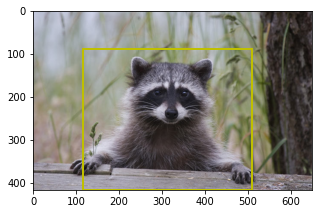

In [ ]:
show_prediction('/content/drive/MyDrive/Datasets/Raccoon_dataset-master/images/raccoon-1.jpg', example_predDict)


## Actividad 12
Cambie la estructura del clasificador (head) del modelo fasterrcnn resnet50 fpn para que permita clasificar ima ́genes de mapaches (el head solo debe realizar esta tarea). Para este propo ́sito utilice el Raccoon Detector Dataset  https://github.com/bing0037/Raccoon dataset

 Para su entrenamiento utilice una estrategia de fine-tunning en base al modelo pre-entrenado en COCO 2017. Realice gráficos de la evolución de las métricas true-positives, false-negatives, false-positives, y precision-recall durante el entrenamiento y verifique el rendimiento en imágenes del set de test.

### **Respuesta:**

In [ ]:

files_dir = '/content/drive/MyDrive/Datasets/Raccoon_dataset-master/images'
test_dir = '/content/drive/MyDrive/Datasets/Raccoon_dataset-master/annotations'

In [ ]:
files_dir = '/content/drive/MyDrive/Magíster en Ciencias de la Ingeniería UC/2021-1_Deep_learning/Raccoon_dataset-master/images'
test_dir = '/content/drive/MyDrive/Magíster en Ciencias de la Ingeniería UC/2021-1_Deep_learning/Raccoon_dataset-master/annotations'

In [ ]:
Image.open("/content/drive/MyDrive/Magíster en Ciencias de la Ingeniería UC/2021-1_Deep_learning/Raccoon_dataset-master/images/raccoon-10.jpg")

Dataset

In [ ]:

class Mapache(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width

        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']


        # classes: 0 index is reserved for background
        self.classes = [_,'raccoon']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0

        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(test_dir, annot_filename)

        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()

        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]

        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))

            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)

            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)


            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height

            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:

            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)

            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])



        return img_res, target

    def __len__(self):
        return len(self.imgs)


# check dataset
dataset = Mapache(files_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[78]
print(img.shape, '\n',target)

length of dataset =  200 

(224, 224, 3) 
 {'boxes': tensor([[ 82.1622,  69.2784, 144.4324, 136.2474]]), 'labels': tensor([1]), 'area': tensor([4170.1821]), 'iscrowd': tensor([0]), 'image_id': tensor([78])}


Ploteo de imagen

In [ ]:
def plot_img_bbox(img, target, plotDict = None):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)

    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'y',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
        if plotDict is not None:
            boxes = predDict['boxes']
            pred_cls = predDict['labels']
            for i in range(len(boxes)):
              cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=3)
              cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=3)
    plt.show()

#img, target = dataset[10]
#plot_img_bbox(img, target)

Finetuning del modelo pre-entrenado

In [ ]:

def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # número de input features para el clasificador
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Reemplazo del head previamente entrenado por uno nuevo.

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
def get_transform(train):

    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
# dataset Mapache y transformaciones
dataset = Mapache(files_dir, 224, 224, transforms= get_transform(train=True))
dataset_test = Mapache(files_dir, 224, 224, transforms= get_transform(train=True))

# split el dataset en sets de train y test
torch.manual_seed(25)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training y validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:

# entrena en gpu si se selecciona
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2

# obtener el modelo
model = get_object_detection_model(num_classes)

# modelo al device correcto
model.to(device)

# optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(params, lr = 1e-4)
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
def bbox_overlaps(bboxes1, bboxes2, mode='iou', is_aligned=False):
    assert mode in ['iou', 'iof']

    rows = bboxes1.size(0)
    cols = bboxes2.size(0)
    if is_aligned:
        assert rows == cols

    if rows * cols == 0:
        return bboxes1.new(rows, 1) if is_aligned else bboxes1.new(rows, cols)

    if is_aligned:
        lt = torch.max(bboxes1[:, :2], bboxes2[:, :2])  # [rows, 2]
        rb = torch.min(bboxes1[:, 2:], bboxes2[:, 2:])  # [rows, 2]

        wh = (rb - lt + 1).clamp(min=0)  # [rows, 2]
        overlap = wh[:, 0] * wh[:, 1]
        area1 = (bboxes1[:, 2] - bboxes1[:, 0] + 1) * (
            bboxes1[:, 3] - bboxes1[:, 1] + 1)

        if mode == 'iou':
            area2 = (bboxes2[:, 2] - bboxes2[:, 0] + 1) * (
                bboxes2[:, 3] - bboxes2[:, 1] + 1)
            ious = overlap / (area1 + area2 - overlap)
        else:
            ious = overlap / area1
    else:
        lt = torch.max(bboxes1[:, None, :2], bboxes2[:, :2])  # [rows, cols, 2]
        rb = torch.min(bboxes1[:, None, 2:], bboxes2[:, 2:])  # [rows, cols, 2]

        wh = (rb - lt + 1).clamp(min=0)  # [rows, cols, 2]
        overlap = wh[:, :, 0] * wh[:, :, 1]
        area1 = (bboxes1[:, 2] - bboxes1[:, 0] + 1) * (
            bboxes1[:, 3] - bboxes1[:, 1] + 1)

        if mode == 'iou':
            area2 = (bboxes2[:, 2] - bboxes2[:, 0] + 1) * (
                bboxes2[:, 3] - bboxes2[:, 1] + 1)
            ious = overlap / (area1[:, None] + area2 - overlap)
        else:
            ious = overlap / (area1[:, None])

    return ious

In [ ]:
from engine import train_one_epoch, evaluate
%load_ext autoreload
%autoreload 2

In [ ]:
# entrenamiento para 20 epochs
num_epochs = 20
train_dict = {'fp': [], 'tp': [], 'fn':[], 'precision': [], 'recall': []}

for epoch in range(num_epochs):
    # entrenamiento para una epoch
    _,epoch_results = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    train_dict['fp'] = train_dict['fp'] + epoch_results['fp']
    train_dict['fn'] = train_dict['fn'] + epoch_results['fn']
    train_dict['tp'] = train_dict['tp'] + epoch_results['tp']
    train_dict['precision'] = train_dict['precision'] + epoch_results['precision']
    train_dict['recall'] = train_dict['recall'] + epoch_results['recall']
    # update el learning rate
    lr_scheduler.step()
    # evaluar en el dataset de test

Epoch: [0]  [ 0/16]  eta: 0:00:55  lr: 0.000338  loss: 1.3234 (1.3234)  loss_classifier: 1.1675 (1.1675)  loss_box_reg: 0.1461 (0.1461)  loss_objectness: 0.0060 (0.0060)  loss_rpn_box_reg: 0.0038 (0.0038)  time: 3.4460  data: 0.5491  max mem: 7999
Epoch: [0]  [10/16]  eta: 0:00:17  lr: 0.003668  loss: 0.4056 (0.6191)  loss_classifier: 0.2655 (0.4685)  loss_box_reg: 0.1339 (0.1383)  loss_objectness: 0.0060 (0.0075)  loss_rpn_box_reg: 0.0048 (0.0047)  time: 2.9616  data: 0.0757  max mem: 8316
Epoch: [0]  [15/16]  eta: 0:00:02  lr: 0.005000  loss: 0.3526 (0.5246)  loss_classifier: 0.2305 (0.3784)  loss_box_reg: 0.1334 (0.1321)  loss_objectness: 0.0074 (0.0093)  loss_rpn_box_reg: 0.0038 (0.0048)  time: 2.9686  data: 0.0606  max mem: 8316
Epoch: [0] Total time: 0:00:47 (2.9749 s / it)
Epoch: [1]  [ 0/16]  eta: 0:00:55  lr: 0.005000  loss: 0.2949 (0.2949)  loss_classifier: 0.1425 (0.1425)  loss_box_reg: 0.1272 (0.1272)  loss_objectness: 0.0204 (0.0204)  loss_rpn_box_reg: 0.0048 (0.0048)  tim

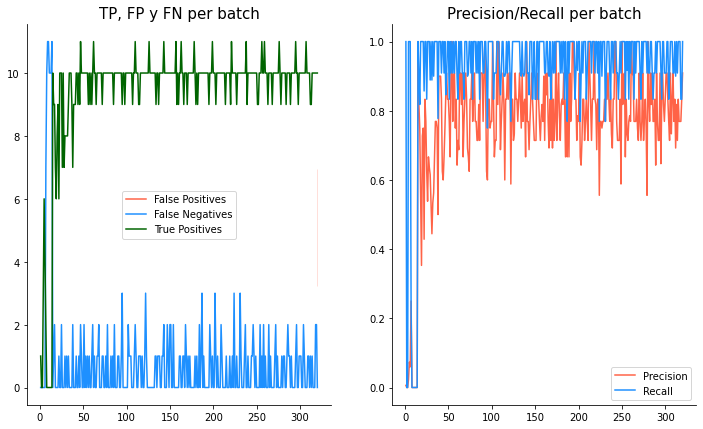

In [ ]:
import seaborn as sn
_, ax = plt.subplots(1,2, figsize = (12,7))

ax[0].set_title('TP, FP y FN per batch', fontsize = 15)
sn.lineplot(x = len(train_dict['fp']), y = train_dict['fp'], label = 'False Positives', ax = ax[0], color = 'tomato')
sn.lineplot(x = range(1, len(train_dict['fn'])+1), y = train_dict['fn'], label = 'False Negatives', ax = ax[0], color = 'dodgerblue')
sn.lineplot(x = range(1, len(train_dict['tp'])+1 ), y = train_dict['tp'], label = 'True Positives', ax = ax[0], color = 'darkgreen')

ax[1].set_title('Precision/Recall per batch', fontsize = 15)
sn.lineplot(x = range(1, len(train_dict['precision'])+1), y = train_dict['precision'], label = 'Precision', ax = ax[1], color = 'tomato')
sn.lineplot(x = range(1, len(train_dict['recall'])+1), y = train_dict['recall'], label = 'Recall', ax = ax[1], color = 'dodgerblue')

plt.legend()
sn.despine()

In [ ]:
#torch.save(model, 'FasterRCNN_resnet50_finetune_20Epoch.pt')


In [ ]:
import pickle
a_file = open("train_dict_FasterRCNN_resnet50_finetune_20Epoch.pkl", "wb")
#pickle.dump(train_dict, a_file)

In [ ]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):

    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return transforms.ToPILImage()(img).convert('RGB')


def bbox_overlaps(bboxes1, bboxes2, mode='iou', is_aligned=False):
    assert mode in ['iou', 'iof']

    rows = bboxes1.size(0)
    cols = bboxes2.size(0)
    if is_aligned:
        assert rows == cols

    if rows * cols == 0:
        return bboxes1.new(rows, 1) if is_aligned else bboxes1.new(rows, cols)

    if is_aligned:
        lt = torch.max(bboxes1[:, :2], bboxes2[:, :2])  # [rows, 2]
        rb = torch.min(bboxes1[:, 2:], bboxes2[:, 2:])  # [rows, 2]

        wh = (rb - lt + 1).clamp(min=0)  # [rows, 2]
        overlap = wh[:, 0] * wh[:, 1]
        area1 = (bboxes1[:, 2] - bboxes1[:, 0] + 1) * (
            bboxes1[:, 3] - bboxes1[:, 1] + 1)

        if mode == 'iou':
            area2 = (bboxes2[:, 2] - bboxes2[:, 0] + 1) * (
                bboxes2[:, 3] - bboxes2[:, 1] + 1)
            ious = overlap / (area1 + area2 - overlap)
        else:
            ious = overlap / area1
    else:
        lt = torch.max(bboxes1[:, None, :2], bboxes2[:, :2])  # [rows, cols, 2]
        rb = torch.min(bboxes1[:, None, 2:], bboxes2[:, 2:])  # [rows, cols, 2]

        wh = (rb - lt + 1).clamp(min=0)  # [rows, cols, 2]
        overlap = wh[:, :, 0] * wh[:, :, 1]
        area1 = (bboxes1[:, 2] - bboxes1[:, 0] + 1) * (
            bboxes1[:, 3] - bboxes1[:, 1] + 1)

        if mode == 'iou':
            area2 = (bboxes2[:, 2] - bboxes2[:, 0] + 1) * (
                bboxes2[:, 3] - bboxes2[:, 1] + 1)
            ious = overlap / (area1[:, None] + area2 - overlap)
        else:
            ious = overlap / (area1[:, None])

    return ious

In [ ]:
# elegir una imagen del conjunto de test
img, target = dataset_test[5]
#  modelo ien evaluación
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  7
real #boxes:  1


Rendimiento en imágenes del set de test

OUTPUT ESPERADO


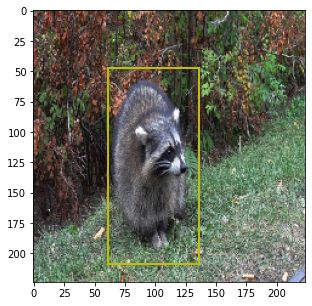

In [ ]:
print('OUTPUT ESPERADO')
plot_img_bbox(torch_to_pil(img), target)

 OUTPUT DEL MODELO


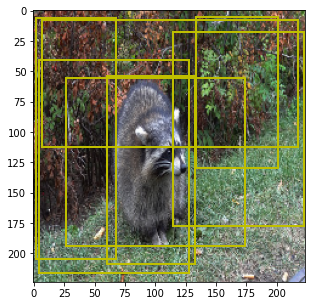

In [ ]:
print(' OUTPUT DEL MODELO')
plot_img_bbox(torch_to_pil(img), prediction)

Uso de NMS

Disminuye la cantidad de bounding boxes

NON-MAXIMUN SUPPRESION APLICADO AL MODELO


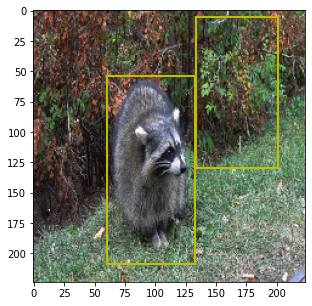

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.0001)
print('NON-MAXIMUN SUPPRESION APLICADO AL MODELO')
plot_img_bbox(torch_to_pil(img), nms_prediction)

In [ ]:
with torch.no_grad():
  for x_batch, y_batch in data_loader:
    x_batch.to(device)
    y_batch.to(device)

    yhat = apply_nms(model(x_batch)[0])



# IV. REFERENCIAS UTILIZADAS



* https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py
* https://github.com/fastai/courses/blob/master/deeplearning1/nbs/resnet50.py
* https://keras.io/guides/functional_api/
* https://arxiv.org/abs/1512.03385
* https://github.com/TrasperJ/102-flowers-classfication-with-PyTorch/blob/master/102flower_classification.ipynb
* https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/df1f5ef1c1a8e1a111e88281b27829fe/finetuning_torchvision_models_tutorial.ipynb#scrollTo=8ph_dMcKjxnO
* https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
* https://pytorch.org/hub/pytorch_vision_vgg/
* https://www.kaggle.com/yerramvarun/fine-tuning-faster-rcnn-using-pytorch
* https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/
* https://towardsdatascience.com/evaluating-performance-of-an-object-detection-model-137a349c517b


